'''
Based on an example from 
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Using a GPU trained deep-learning framework to predict time series data.

Specifically we are using a Long Short-Term Memor network

The data is from the BOM and is the daily maximum temperatures.

A problem might be, given the last few decades of temperature cycles, 
what will next years' be?

'''

In [1]:
#import all the libraries we need
import numpy
import time
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MaxAbsScaler 

In [2]:
#Load in the dataset
filename='sydney_temperature.csv'
dataframe = pd.read_csv(filename, usecols=[5], engine='python')
dataset = dataframe.dropna()
dataset = dataset.values
dataset = dataset.astype('float32')

# normalize the dataset to be betwenn 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
datasetScaled = scaler.fit_transform(dataset)


In [3]:
#Print some stats about the data
print(dataframe.describe())

       Maximum temperature (Degree C)
count                    58316.000000
mean                        21.731120
std                          4.669517
min                          7.700000
25%                         18.200000
50%                         21.600000
75%                         24.900000
max                         45.800000


Text(0, 0.5, 'Temperature (degrees Celsius)')

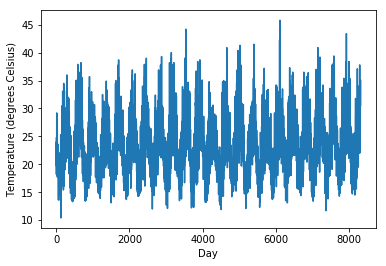

In [4]:
#Look at some of the data set
#This is the temperature throughout the year.
#The summer and winter cycles are obvious
#But there is a fair bit of variablity day-to-day
plt.plot(dataset[50000:])
plt.xlabel("Day")
plt.ylabel("Temperature (degrees Celsius)")

In [5]:
# split into train and test sets
#Use the first 58000 days as training
train=datasetScaled[50000:58000,:]
#Use from 50000 to 58316 as testing set, 
#that means we will test on 8000 days we know the answer for, 
#leaving 316 that the algorithm has never seen!
test=datasetScaled[55000:,:]

print("Traing set is: ", train.shape)
print("Test set is: ", test.shape)

Traing set is:  (8000, 1)
Test set is:  (3316, 1)


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# previous time steps to use as input variables to predict the next time period
look_back = 30 

# reshape into X=t and Y=t+look_back
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [7]:
# create the LSTM network
#The network has a visible layer with 1 input, 
#a hidden layer with 4 LSTM blocks or neurons, 
#and an output layer that makes a single value prediction. 
#The default sigmoid activation function is used for the LSTM blocks. 
#The network is trained for 4 epochs and a batch size of 1 is used.

print("Running model...")
model = tf.keras.models.Sequential()

print("Adding LSTM.")
model.add(tf.keras.layers.LSTM(4, input_shape=(look_back, 1)))

print("Adding dense.")
model.add(tf.keras.layers.Dense(1))

print("Compiling.")
model.compile(loss='mean_squared_error', optimizer='adam')

Running model...
Adding LSTM.
Adding dense.
Compiling.


In [8]:
#Fit the model, this takes the longest time
print("fitting...")
startT=time.time()
model.fit(trainX, trainY, epochs=4, batch_size=30, verbose=1)
endT=time.time()

print("Time taken: ", endT-startT)

fitting...
Epoch 1/4
7969/7969 [==============================] - 13s 2ms/step - loss: 0.1379
Epoch 2/4
7969/7969 [==============================] - 11s 1ms/step - loss: 0.0151
Epoch 3/4
7969/7969 [==============================] - 10s 1ms/step - loss: 0.0099
Epoch 4/4
7969/7969 [==============================] - 9s 1ms/step - loss: 0.0080
Time taken:  43.531500577926636


In [9]:
#Save or load the model
#model.save('kerasmodel.hdf5')
#model = tf.keras.models.load_model('kerasmodel.hdf5')

In [10]:
#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert and rescale predictions
trainPredicti = scaler.inverse_transform(trainPredict)
trainYi = scaler.inverse_transform([trainY])
testPredicti = scaler.inverse_transform(testPredict)
testYi = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYi[0], trainPredicti[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYi[0], testPredicti[:,0]))
print('Test Score: %.4f RMSE' % (testScore))


Train Score: 3.3662 RMSE
Test Score: 3.3649 RMSE


(55000, 1) (3285, 1) (58316, 1)
(7969, 1) (3285, 1) (58285, 1)


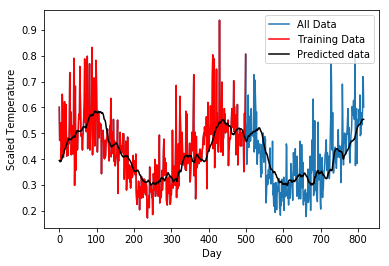

In [13]:
#PLOT the result

#Create a dataset that is the same size as the testing/training set 
dummyfull=numpy.ones((datasetScaled.shape[0]-test.shape[0],1))*numpy.mean(testPredict)
print(dummyfull.shape,testPredicti.shape,datasetScaled.shape)
testvec = numpy.concatenate((dummyfull,testPredict))

#Scale the data
transformer = MaxAbsScaler().fit(train[:])
testScale= transformer.transform(testvec)

print(trainPredict.shape,testPredict.shape,testvec.shape)

#do some funky things with the plotting just so we can look at a bit of it
zoomscale=-500
unseenPredicted = datasetScaled.shape[0]-train.shape[0]-50000

plt.plot(datasetScaled[zoomscale-unseenPredicted:])
plt.plot(train[zoomscale:],'r')
plt.plot(testScale[zoomscale-unseenPredicted:],'k')

plt.legend(["All Data","Training Data","Predicted data"])
plt.xlabel("Day")
plt.ylabel("Scaled Temperature")
plt.show()